# 4.5 Convergence in the Snake format

How does the ranking behavior in the random snake setup translates into a more realistic scenario? We consider a situation where the notion of ranking is meaningful, where players do have an actual in game level.
One parameter is the state of ranking itself. One question is how rankings evolve from a "wrong" state to a more correct one. The worst-case scenario is when the best player has the lowest ratings and the weakest player the highest. That state can be obtained by letting a ranking converge to the consensus ranking and then applying a permutation on the players and reassigning corresponding ratings.

This can challenge rankings learning in skilled based matchmaking because, when reversing the ranking, we do not change much the game balance in the snake format.

## 4.5.2 Protocol
I perform a comparative study on Elo, Glicko, TrueSkill and PlackettLuce. I had one more ranking to the pool, the final standing of the snake competition - **players sort them-selves out**. The metric of evaluation is rank correlation with the consensus ranking. In the middle of the simulation rankings are applied a permutation where player at rank i = 0, ...., n − 1 receive the rating of player at rank n − 1 − i. The ranking is reversed. The experiments is repeated for different population sizes. I perform an RSSC loop, and the duration of the simulation is 150 Snake tournament editions before the permutation and 150 afterward.

**parameters**:

- **players**: 8, 16, 32, 64, 128, 256, 512 of constant level
- **game type**: one-versus-one
- **Scheduler**: Snake
- **Solver**: LogSolver
- **Interaction**: RSSC loop, depth=150  x 2

  

The resulting games are stored in 7 populations · 5 rankings · 2 = 105 datasets. The smallest one contains 2100 games and the biggest 230’000.

In [1]:
from rstt import BasicPlayer, LogSolver, Snake, BTRanking, SuccessRanking
from rstt import SingleEliminationBracket as SEB
from rstt import DoubleEliminationBracket as DEB

from utils.commons import rankings
from utils import rssc

# players
sizes = [8, 16, 32, 64, 128, 256, 512]
populations = [BasicPlayer.create(nb=n) for n in sizes]
gts = [BTRanking(name=f'{len(pop)} gt', players=pop) for pop in populations]

# scheduler
schedulers = [Snake, SEB, DEB]

# solver
solver = LogSolver()

# depth
depth = 160

In [ ]:
from functools import partial
from utils.metrics import ktcorr

from IPython.display import clear_output
import tqdm


# results
results = {}

# simulation
for pop, gt in zip(populations, gts):
    metric = partial(ktcorr, gt=gt)
    for scheduler in schedulers:
        point_system = {i: len(pop)+1-i for i in range(1, len(pop)+1)}
        sr = SuccessRanking('PreviousRank', window_range=1, players=pop, default=point_system)
        for ranking in rankings(pop) + [sr]:
            # normal
            exp_name = f'{ranking.name} x {scheduler.__name__} x {len(pop)} x normal'
            results[exp_name] = rssc(exp_name, ranking, scheduler, solver, depth, metric)

            # reverse
            exp_name = f'{ranking.name} x {scheduler.__name__} x {len(pop)} x reverse'
            ranking.rerank(permutation=list(range(len(pop)-1, -1, -1)))
            results[exp_name] = rssc(exp_name, ranking, scheduler, solver, depth, metric)


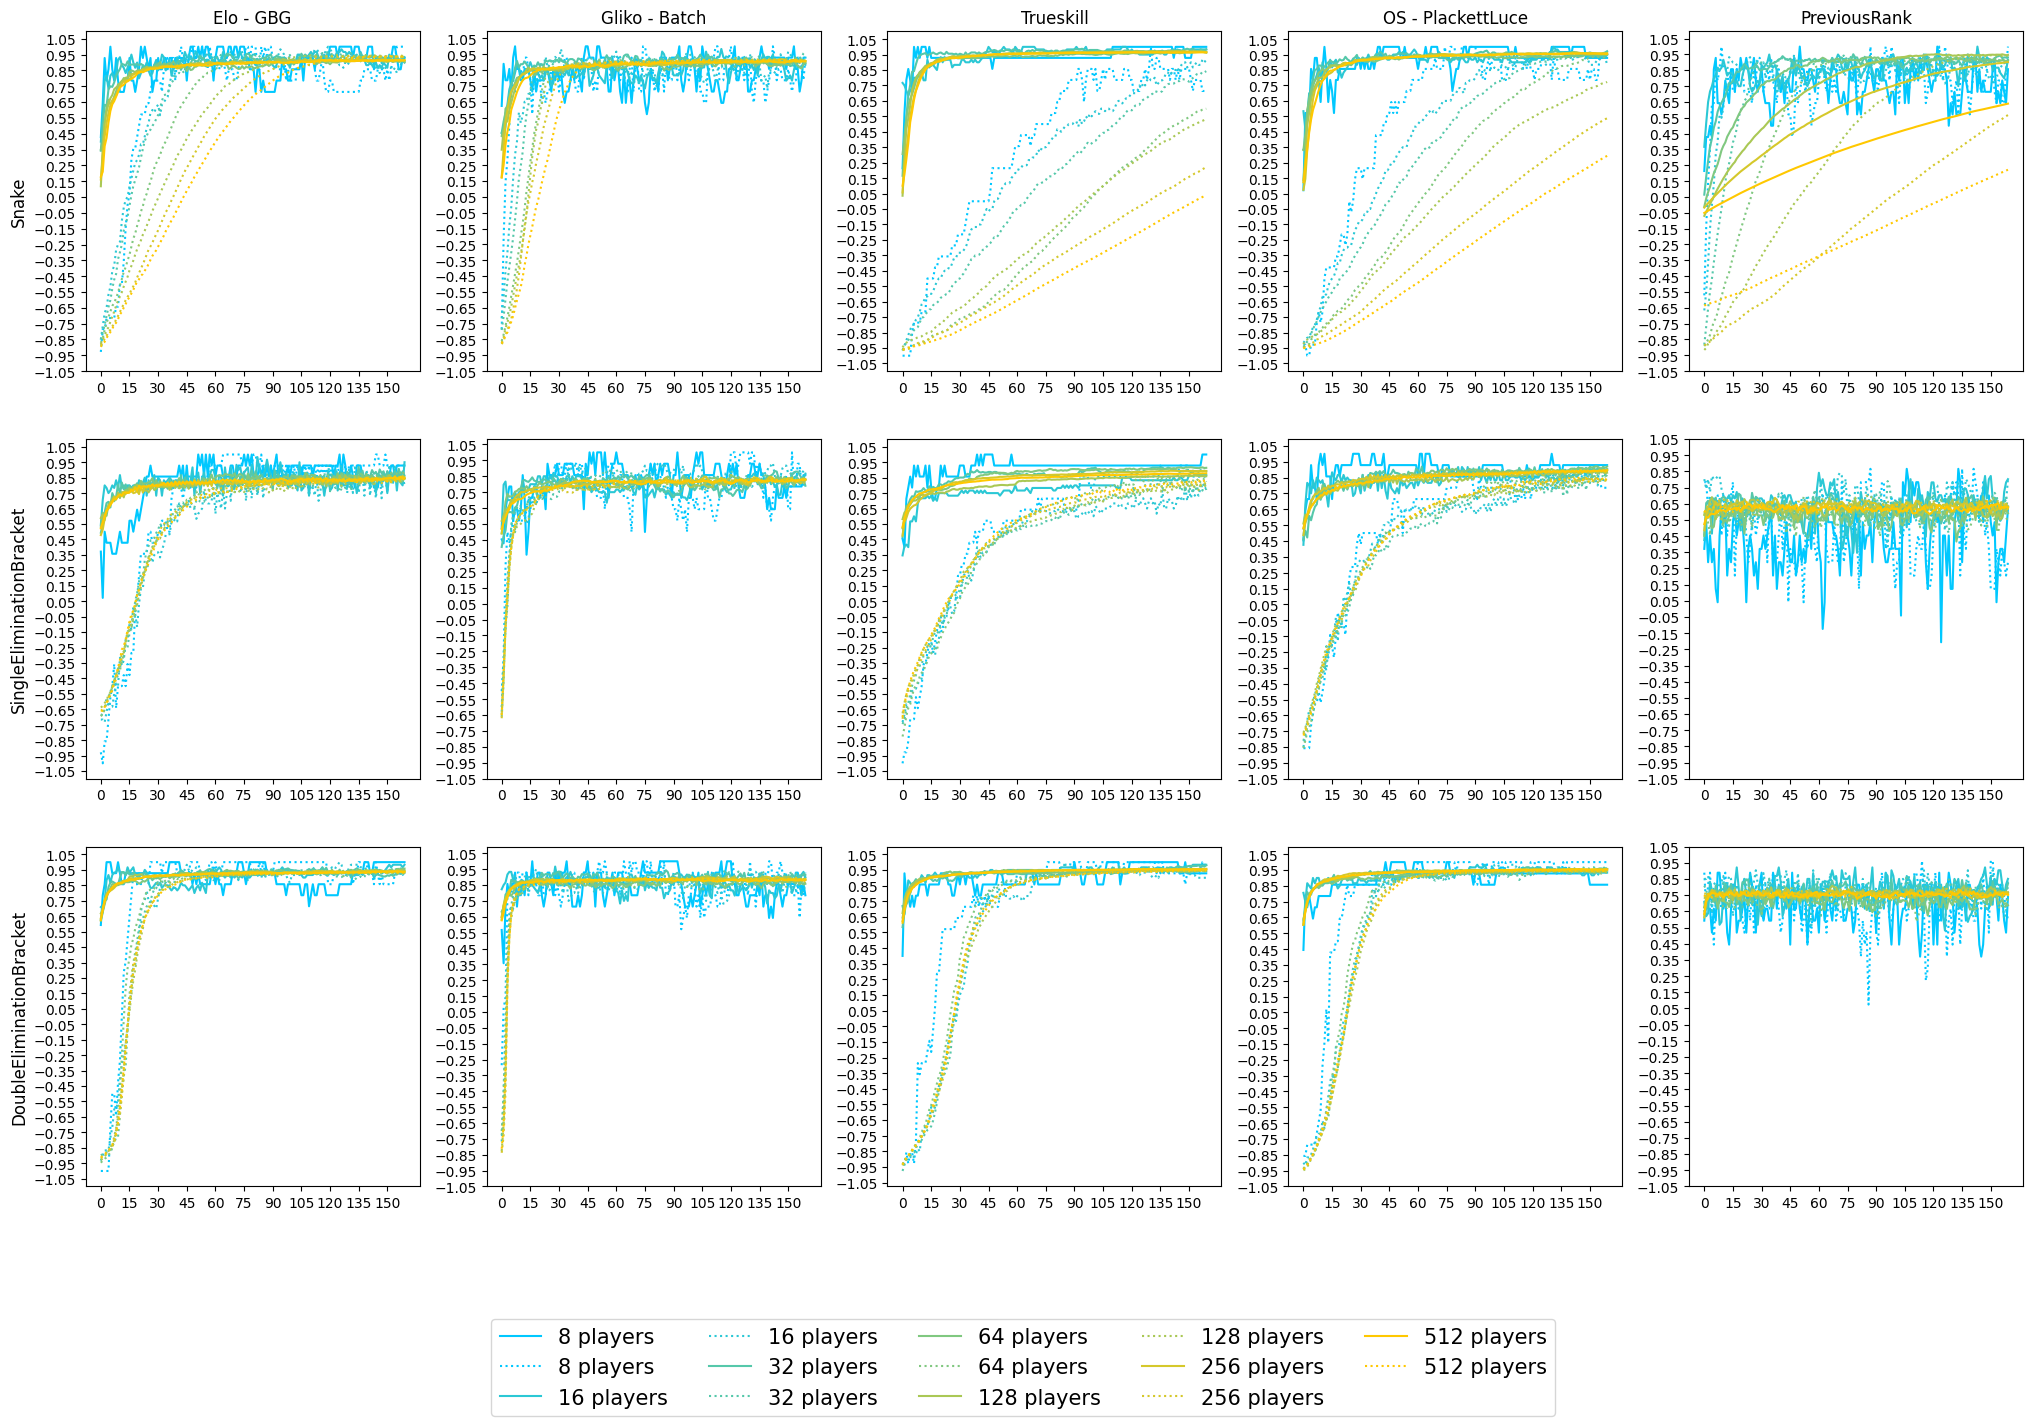

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils.visualisation import colorgradient


COLORS = colorgradient((0,200,255), (255,200,0), len(sizes))
COLORS = {s: c for s, c in zip(sizes, COLORS)}

rows = len(schedulers)
cols = len(rankings(None)) + 1
xticks = np.arange(0, depth, 15)
yticks = np.arange(-1.05, 1.06, 0.1)

fig, axs = plt.subplots(rows, cols, figsize=(5*cols,5*rows))
cols_name = [r.name for r in rankings(None)+ [sr]] 
rows_name = [f.__name__ for f in schedulers]
for ax, col in zip(axs[0], cols_name):
    ax.set_title(col)
for ax, row in zip(axs[:,0], rows_name):
    ax.set_ylabel(row, rotation=90, size='large')


for title, corrs in results.items():
    r, f, s, ini = title.split(' x ')    
    ax = axs[rows_name.index(f)][cols_name.index(r)]
    if ini == 'normal':
        ax.plot(corrs, c=COLORS[int(s)], label=s + ' players', linestyle='solid')
    if ini == 'reverse':
        ax.plot(corrs, c=COLORS[int(s)], label=s + ' players', linestyle='dotted')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

lines, labels = axs[0][0].get_legend_handles_labels()
fig.legend(lines, labels, loc='lower center', ncols=5, bbox_to_anchor=(0.5, -0.05), fontsize=15)
plt.show()

## 4.5.3 Results

As we can see, in the normal case (continuous lines), the rankings converge fast to the consensus ranking. In the Snake format, they all reach a rank correlation around 0.9. Simply put, rankings do what they are supposed to do. They rate and order players based on their skills.

In the Single Elimination Bracket, the correlation is lower, around 0.75-0.8. This should not come as a surprise. Section 4.2 shows how the bracket affects a dataset and the learning of the Elo. From this picture, we can see that the rank correlation of Glicko, TrueSkill and PlackettLuce is consistent with the Elo in the same setting.

Where things get interesting is when we look at the dotted lines, the ’worst case scenario’ when rankings are reversed and intentional put at around -1.0 rank correlation. We can see that it takes significantly more time for TrueSkill and PlackettLuce to reach the consensus ranking. Elo and Glicko need less time, fewer games to capture the real level of the participants. To put into perspective the performances. Take a look at the dark blue dotted line; 8 players are sorted in reverse order, the better player is rated the worst. It takes TrueSkill more than 90 snake editions to sort them, this period consists of about 630 games. 630 games were played among 8 players, facing each other again and again.

If you look at the "previous Rank" in the same context, the 8 players are sorted in less than 10 editions. This setting is without a ranking intervention, it is when we use the final placement as seeding for the next edition. Basically, players sort themselves out naturally faster than in a TrueSkill environment. This shows the hard-stuck and boosted players problematics as a strict consequence of the interaction between a ranking algorithm and a scheduler.

## Further Notes

Rank correlation fails to capture eveything relevant to the experiments. During simulation, The Glicko ranking raises warning about a 0 division which happens when the expected score of a player is 100%. Analicicaly this can not happen. However in a numerical computation, 0.999999999999999999999999999 is rounded to 1. RSST deals with it by adjusting the estimate value to 0.99999999999999 (apologize for the approximation).

In the second part of the simulation, for larger population, althought glicko sorts player fast, it does it while producing unreasonable rating values.

This Github issue: https://github.com/sublee/glicko/issues/2 , on another implementation of the algorithm also mention a ZeroDivisionError without justifying the rating values. Here it arraise in a reproducible context.


